In [24]:
import numpy as np
import matplotlib.pyplot as plt
from JOPLEn.singletask import JOPLEn
from JOPLEn.st_penalty import NuclearNorm, SquaredFNorm, SquaredLaplacian
from JOPLEn.st_loss import SquaredError
from JOPLEn.partitioner import VPartition
from JOPLEn.enums import CellModel
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

n_points = 10000
n_train_points = 100
n_cells = 5
n_partitions = 20

In [2]:
np.random.seed(0)

x = np.random.uniform(-1, 1, (n_points, 2))
y = np.sin(np.pi * x[:, 0] + x[:, 1]) + np.random.normal(0, 0.2, n_points)

x_train = x[:n_train_points]
y_train = y[:n_train_points, None]

x_test = x[n_train_points:]
y_test = y[n_train_points:, None]

In [132]:
model = JOPLEn(
    partitioner=VPartition,
    n_cells=n_cells,
    n_partitions=n_partitions,
    loss_fn=SquaredError,
    cell_model=CellModel.linear,
    mu=1e-1,
    max_iters=1000,
    rescale=False,
    regularizers=[
        SquaredFNorm(1e-3),
    ],
)

history = model.fit(x_train, y_train, verbose=False)

y_pred_l2 = model.predict(x_test)

print("F error:", mean_squared_error(y_pred_l2, y_test))

F error: 0.20289800026970853


In [42]:
model = LGBMRegressor(
    seed=0,
    verbose=-1,
    n_estimators=n_partitions,
    num_leaves=n_cells,
)

model.fit(x_train, y_train.flatten())

y_pred_lgbm = model.predict(x_test)[:, None]

print("LGBM error:", mean_squared_error(y_pred_lgbm, y_test))

LGBM error: 0.22781659829270903


In [125]:
model_nn = JOPLEn(
    partitioner=VPartition,
    n_cells=n_cells,
    n_partitions=n_partitions,
    loss_fn=SquaredError,
    cell_model=CellModel.linear,
    mu=1e-1,
    max_iters=1000,
    early_stop=True,
    rescale=False,
    regularizers=[
        NuclearNorm(lam=1e-3),
    ],
)

history = model_nn.fit(x_train, y_train)

y_pred_nn = model_nn.predict(x_test)

print("NN error:", mean_squared_error(y_pred_nn, y_test))

NN error: 0.10739606888570075


In [120]:
model = JOPLEn(
    partitioner=VPartition,
    n_cells=n_cells,
    n_partitions=n_partitions,
    loss_fn=SquaredError,
    cell_model=CellModel.constant,
    mu=1e-1,
    max_iters=1000,
    early_stop=True,
    rescale=False,
    regularizers=[
        SquaredFNorm(lam=2 * 1e-2),
    ],
)

history = model.fit(x_train, y_train)

y_pred_pwc = model.predict(x_test)

print("PWC F error:", mean_squared_error(y_pred_pwc, y_test))
# Similar loss to the NN method. However, this is only useful if you know
# a priori that a piecewise constant model is more appropriate. In some settings,
# the data may be linear and then the NN would be better

[08:47:02]: Epoch    100 | TrL: 0.191848 | Obj: 0.045873
[08:47:02]: Epoch    200 | TrL: 0.193161 | Obj: 0.046094
[08:47:02]: Epoch    300 | TrL: 0.193423 | Obj: 0.046144
[08:47:02]: Epoch    400 | TrL: 0.193415 | Obj: 0.046142
[08:47:02]: Epoch    500 | TrL: 0.193377 | Obj: 0.046134
[08:47:03]: Epoch    600 | TrL: 0.193376 | Obj: 0.046134
[08:47:03]: Epoch    700 | TrL: 0.193390 | Obj: 0.046137
[08:47:03]: Epoch    800 | TrL: 0.193400 | Obj: 0.046139
[08:47:03]: Epoch    900 | TrL: 0.193399 | Obj: 0.046138
[08:47:03]: Epoch   1000 | TrL: 0.193393 | Obj: 0.046137
PWC F error: 0.10846633490154545


In [121]:
model = JOPLEn(
    partitioner=VPartition,
    n_cells=n_cells,
    n_partitions=n_partitions,
    loss_fn=SquaredError,
    cell_model=CellModel.linear,
    mu=1e-1,
    max_iters=1000,
    early_stop=True,
    rescale=False,
    regularizers=[
        NuclearNorm(lam=1e-2),
        SquaredLaplacian(lam=0.1 * 1e-3),
    ],
)

history = model.fit(x_train, y_train)

y_pred_nnl = model.predict(x_test)

print("NN+L error:", mean_squared_error(y_pred_nnl, y_test))

NN+L error: 0.09966073841263673


In [122]:
model = JOPLEn(
    partitioner=VPartition,
    n_cells=n_cells,
    n_partitions=n_partitions,
    loss_fn=SquaredError,
    cell_model=CellModel.constant,
    mu=1e-1,
    max_iters=1000,
    early_stop=True,
    rescale=False,
    regularizers=[
        SquaredFNorm(lam=2 * 1e-2),
        SquaredLaplacian(lam=0.1 * 1e-2),
    ],
)

history = model.fit(x_train, y_train)

y_pred_l2l = model.predict(x_test)

print("L2+L error:", mean_squared_error(y_pred_l2l, y_test))
# Similar loss to the NN method. However, this is only useful if you know
# a priori that a piecewise constant model is more appropriate. In some settings,
# the data may be linear and then the NN would be better

[08:47:03]: Epoch    100 | TrL: 0.192340 | Obj: 0.048338
[08:47:03]: Epoch    200 | TrL: 0.193647 | Obj: 0.048559
[08:47:04]: Epoch    300 | TrL: 0.193907 | Obj: 0.048609
[08:47:04]: Epoch    400 | TrL: 0.193900 | Obj: 0.048607
[08:47:04]: Epoch    500 | TrL: 0.193862 | Obj: 0.048599
[08:47:04]: Epoch    600 | TrL: 0.193861 | Obj: 0.048599
[08:47:04]: Epoch    700 | TrL: 0.193875 | Obj: 0.048602
[08:47:04]: Epoch    800 | TrL: 0.193885 | Obj: 0.048604
[08:47:04]: Epoch    900 | TrL: 0.193884 | Obj: 0.048604
[08:47:04]: Epoch   1000 | TrL: 0.193878 | Obj: 0.048602
L2+L error: 0.10852265791165727


/tmp/ipykernel_3543878/3669349102.py:66: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



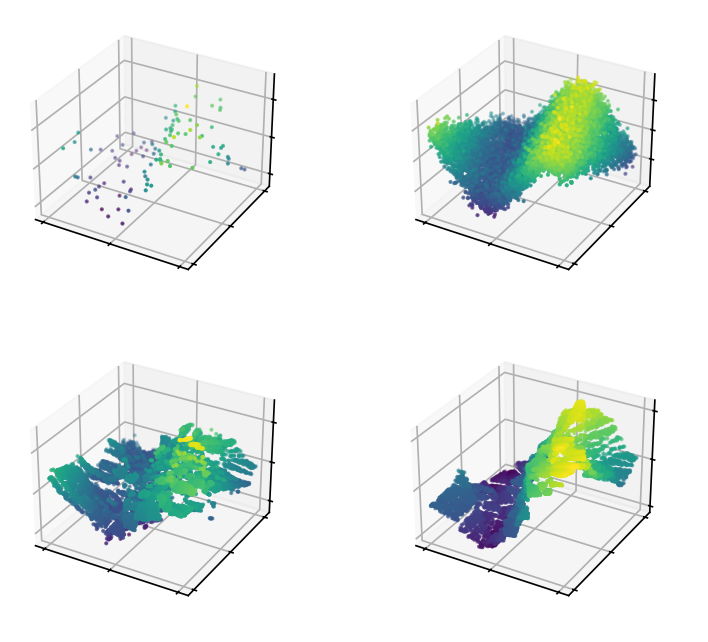

F-Norm Penalty Loss:       0.2029
Nuclear Norm Penalty Loss: 0.1074
LGBM Loss:                 0.2278


In [123]:
# Create a figure and a grid layout with 1 row and 2 columns
fig = plt.figure(dpi=150, figsize=(6, 8))

# Add the first subplot
axs = [fig.add_subplot(320 + i, projection="3d") for i in range(1, 5)]

shared_params = {
    "s": 1,
}

axs[0].scatter(
    x_train[:, 0],
    x_train[:, 1],
    y_train,
    c=y_train,
    **shared_params,
)
# axs[0].set_title("Training Data")

axs[1].scatter(
    x_test[:, 0],
    x_test[:, 1],
    y_test,
    c=y_test,
    **shared_params,
)
# axs[1].set_title("Testing Data")

axs[2].scatter(
    x_test[:, 0],
    x_test[:, 1],
    y_pred_l2,
    c=y_pred_l2,
    **shared_params,
)
# axs[2].set_title("F-Norm")

axs[3].scatter(
    x_test[:, 0],
    x_test[:, 1],
    y_pred_nn,
    c=y_pred_nn,
    **shared_params,
)
# axs[3].set_title("Nuclear Norm")

# axs[4].scatter(
#     x_test[:, 0],
#     x_test[:, 1],
#     y_pred_lgbm,
#     c=y_pred_lgbm,
#     **shared_params,
# )
# axs[4].set_title("Prediction with LGBM")

for ax in axs:
    # ax.set_xlabel("X1")
    # ax.set_ylabel("X2")
    # ax.set_zlabel("Y")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

# plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.tight_layout()

plt.show()

print(f"F-Norm Penalty Loss:       {np.mean((y_test - y_pred_l2) ** 2):.4f}")
print(f"Nuclear Norm Penalty Loss: {np.mean((y_test - y_pred_nn) ** 2):.4f}")
print(f"LGBM Loss:                 {np.mean((y_test - y_pred_lgbm) ** 2):.4f}")

In [126]:
w = model_nn.get_weights()
np.linalg.svd(w, compute_uv=False)
# not a rank 1 matrix, so it's not just learning piecewise-constant functions

array([0.36699164, 0.22095507, 0.19031078], dtype=float32)

In [134]:
import plotly.graph_objs as go

# Create a scatter plot
scatter_plot = go.Scatter3d(
    x=x_test[:, 0],
    y=x_test[:, 1],
    z=y_pred_nn.flatten(),
    mode="markers",
    marker=dict(
        color=y_pred_nn.flatten(),
        colorscale="Viridis",  # You can choose any other colorscale
        opacity=0.8,
        size=3,
    ),
)

# Define layout parameters
layout = go.Layout(
    title="3D Scatter Plot of Predictions",
    scene=dict(
        xaxis=dict(title="Feature 1"),
        yaxis=dict(title="Feature 2"),
        zaxis=dict(title="Predicted Class"),
    ),
    # width=800,  # Adjust width as needed
    height=800,  # Adjust height as needed
)

# Create a Figure object
fig = go.Figure(data=[scatter_plot], layout=layout)

# Show the plot
fig.show()